### Load CADETSettings
This imports all the standard libraries and provides some helper functions.

In [28]:
%run ../utils_macos.ipynb

/Users/hoangnguyen/ipykernel_42339/4087898338.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/Users/hoangnguyen/ipykernel_42339/4087898338.py:3: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


In [57]:
# Auxiliary variables
t_cycle = 100

init_c = [1.0, 0.0]                                         # mol/m^3

kfwd = [0.01]                                              # m^3/(mol.s)
kbwd = [0.0]                                                # m^3/(mol.s)

stoich = [-1, 
           1]

n_comp = len(init_c)

In [58]:
# CSTR
V_cstr = 0.05                                               # m^3                                                    
Q_cstr = 0.001                                              # m^3/s                                                
tau_cstr = V_cstr/Q_cstr                                    # s
t_cycle = 1200                                              # s                                             


# PFR presenting tubings between CSTR
length = 0.025                                              # m
cross_section_area = 0.01                                   # m^2

model = get_cadet_template(n_units=5)

# Unit operations
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# CSTR 1
model.root.input.model.unit_001.unit_type = 'CSTR'
model.root.input.model.unit_001.ncomp = n_comp
model.root.input.model.unit_001.init_volume = V_cstr
model.root.input.model.unit_001.init_c = init_c

# PFR
model.root.input.model.unit_002.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
model.root.input.model.unit_002.ncomp = n_comp
model.root.input.model.unit_002.col_length = length
model.root.input.model.unit_002.cross_section_area = cross_section_area
model.root.input.model.unit_002.total_porosity = 1
model.root.input.model.unit_002.col_dispersion = 0
model.root.input.model.unit_002.init_c = init_c

# CSTR 2
model.root.input.model.unit_003.unit_type = 'CSTR'
model.root.input.model.unit_003.ncomp = n_comp
model.root.input.model.unit_003.init_volume = V_cstr
model.root.input.model.unit_003.init_c = init_c

# Outlet
model.root.input.model.unit_004.unit_type = 'OUTLET'
model.root.input.model.unit_004.ncomp = n_comp

model.root.input.solver.sections.nsec = 1
model.root.input.solver.sections.section_times = [0.0, t_cycle]
model.root.input.solver.sections.section_continuity = []
model.root.input.solver.user_solution_times = np.linspace(0, t_cycle, 1001)

model.root.input.model.unit_000.sec_000.const_coeff = init_c

model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, Q_cstr,
    1, 2, -1, -1, Q_cstr,
    2, 3, -1, -1, Q_cstr,
    3, 4, -1, -1, Q_cstr,
]

In [59]:
# Reaction
# CSTR 1
model.root.input.model.unit_001.reaction_model = 'MASS_ACTION_LAW'
model.root.input.model.unit_001.reaction_bulk.mal_kfwd_bulk = kfwd
model.root.input.model.unit_001.reaction_bulk.mal_kbwd_bulk = kbwd
model.root.input.model.unit_001.reaction_bulk.mal_stoichiometry_bulk = stoich

# CSTR 2
model.root.input.model.unit_003.reaction_model = 'MASS_ACTION_LAW'
model.root.input.model.unit_003.reaction_bulk.mal_kfwd_bulk = kfwd
model.root.input.model.unit_003.reaction_bulk.mal_kbwd_bulk = kbwd
model.root.input.model.unit_003.reaction_bulk.mal_stoichiometry_bulk = stoich

In [60]:
# Preparing to run simulation
set_discretization(model)

In [61]:
# Running simulation
run_simulation(model)

Simulation completed successfully


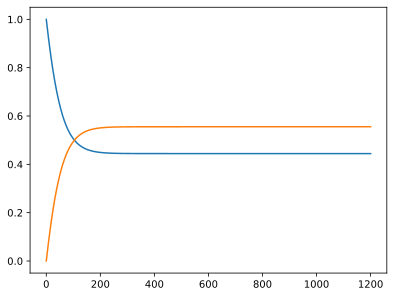

In [62]:
time = model.root.output.solution.solution_times
solution_outlet = model.root.output.solution.unit_004.solution_outlet
plt.plot(time, solution_outlet)